### 1. Import required librarise 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    LeaveOneOut,
)
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    make_scorer,
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import statsmodels.api as sm
from pygam import LinearGAM, s
from scipy import stats

from hailing_ski import test_time_series

### 2. Preliminary analysis of the data set

In [4]:
# Load and check the data
full_data = pd.read_csv("./California-data.csv", na_values="?")

print("Data structure:")
print(full_data.dtypes)

# Remove id as it is not useful for prediction
full_data = full_data.drop(columns=["id"])

# Clear missing data
full_data = full_data.dropna()

# Check and convert categorical variable to dummy variables
print("\nUnique categories in 'oceanProximity':")
print(full_data["oceanProximity"].value_counts())
full_data = pd.get_dummies(
    full_data,
    columns=["oceanProximity"],
    prefix="oceanProximity",
    dtype="float",
    drop_first=True,
)

# Replace spaces and special characters in column names
full_data = full_data.rename(columns=lambda x: x.replace(" ", "_"))
full_data = full_data.rename(columns=lambda x: x.replace("<", "less_than_"))

# Split the data into training and testing sets
train_data, test_data = train_test_split(full_data, test_size=0.2, random_state=1)

print("\nData summary:")
print(train_data.describe())

print(train_data.head())

Data structure:
id                    int64
longitude           float64
latitude            float64
housingMedianAge      int64
aveRooms            float64
aveBedrooms         float64
population            int64
medianIncome        float64
medianHouseValue    float64
oceanProximity       object
dtype: object

Unique categories in 'oceanProximity':
oceanProximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64

Data summary:
          longitude      latitude  housingMedianAge      aveRooms  \
count  16346.000000  16346.000000      16346.000000  16346.000000   
mean    -119.569609     35.629776         28.619601      5.408491   
std        2.001760      2.132851         12.589470      2.268166   
min     -124.350000     32.540000          1.000000      0.846154   
25%     -121.800000     33.930000         18.000000      4.443964   
50%     -118.490000     34.260000         29.000000      5.227170   
75%     -118.010

All predictor variables are numerical except for oceanProximity, where the ISLAND category has only 5 observations.

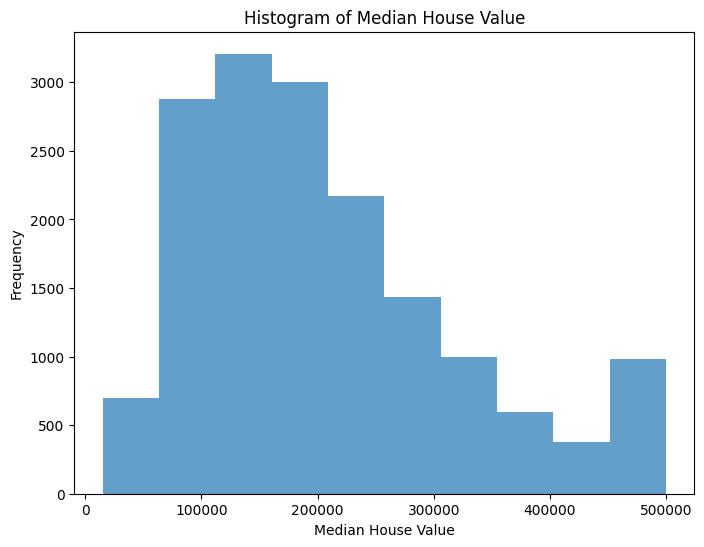

In [5]:
# Visualize the distribution of the response variable
plt.figure(figsize=(8, 6))
plt.hist(train_data["medianHouseValue"], alpha=0.7)
plt.title("Histogram of Median House Value")
plt.xlabel("Median House Value")
plt.ylabel("Frequency")
plt.show()

It appears that the 'medianIncome' variable is right-censored at a value of 150001.


Histograms of numeric predictors in the full training dataset:


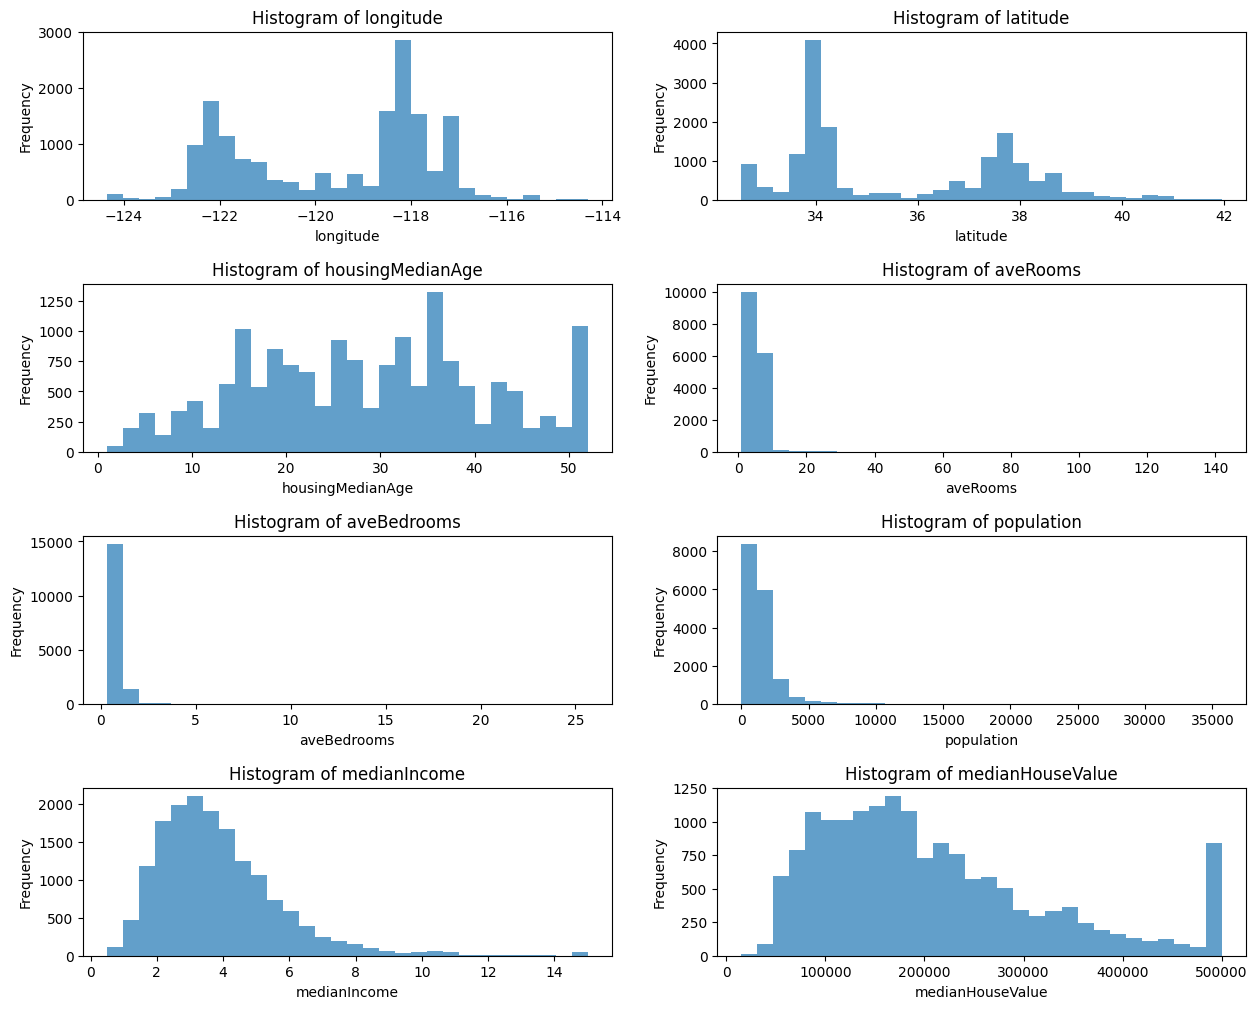

Censored house value: 500001.0

Histograms of numeric predictors in the truncated training dataset:


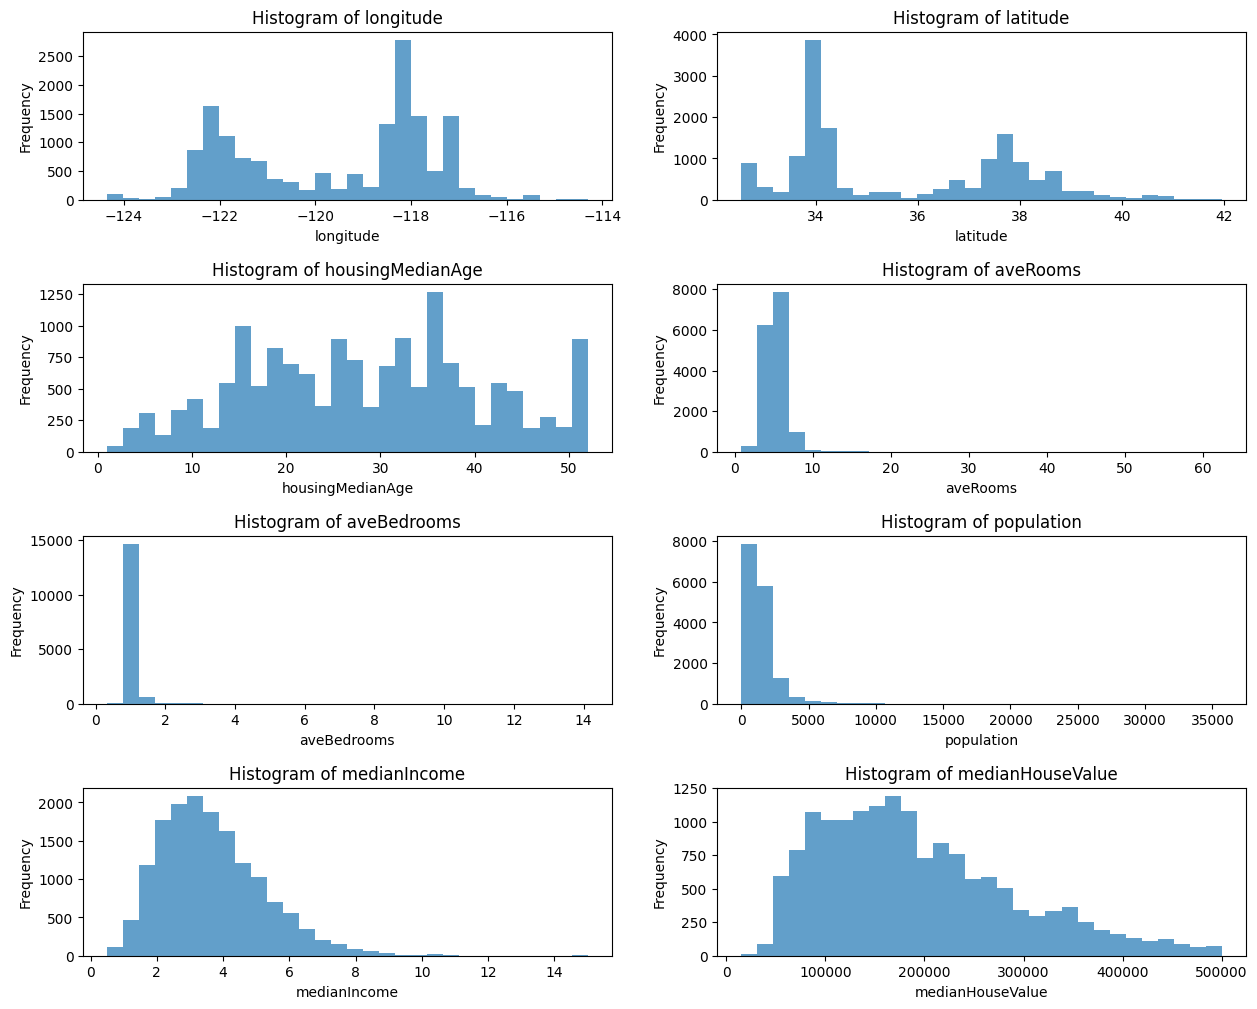

In [6]:
# Visualize the distribution of numeric predictors in the full training dataset
print("\nHistograms of numeric predictors in the full training dataset:")
fig, axes = plt.subplots(4, 2, figsize=(15, 12))
axes = axes.ravel()
numeric_cols = train_data.select_dtypes(include=[np.number]).columns

for i, col in enumerate(numeric_cols):
    if i < len(axes):
        axes[i].hist(train_data[col], bins=30, alpha=0.7)
        axes[i].set_title(f"Histogram of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")

plt.subplots_adjust(hspace=0.5)  # Increase vertical space between rows
plt.show()

# Visualize the distribution of mnumeric predictors in the truncated training dataset
censor_houseValue = train_data["medianHouseValue"].max()
print(f"Censored house value: {censor_houseValue}")
rt_train_data = train_data[train_data["medianHouseValue"] < censor_houseValue]
rt_test_data = test_data[test_data["medianHouseValue"] < censor_houseValue]

print("\nHistograms of numeric predictors in the truncated training dataset:")
fig, axes = plt.subplots(4, 2, figsize=(15, 12))
axes = axes.ravel()
numeric_cols = rt_train_data.select_dtypes(include=[np.number]).columns

for i, col in enumerate(numeric_cols):
    if i < len(axes):
        axes[i].hist(rt_train_data[col], bins=30, alpha=0.7)
        axes[i].set_title(f"Histogram of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")

plt.subplots_adjust(hspace=0.5)  # Increase vertical space between rows
plt.show()

The distributions after filtering out the right-censored 'medianHouseValue' seems to follow a similar pattern of the full dataset, which suggests that the right-truncated dataset can be used as a reasonable approximation to the full dataset.

In [7]:
# Create correlation matrix
print("\nCorrelation matrix:")
print(train_data.corr().round(2))


Correlation matrix:
                           longitude  latitude  housingMedianAge  aveRooms  \
longitude                       1.00     -0.92             -0.11     -0.03   
latitude                       -0.92      1.00              0.01      0.10   
housingMedianAge               -0.11      0.01              1.00     -0.16   
aveRooms                       -0.03      0.10             -0.16      1.00   
aveBedrooms                     0.02      0.06             -0.09      0.82   
population                      0.10     -0.11             -0.30     -0.07   
medianIncome                   -0.02     -0.07             -0.11      0.36   
medianHouseValue               -0.05     -0.14              0.11      0.17   
oceanProximity_INLAND          -0.06      0.35             -0.24      0.16   
oceanProximity_ISLAND           0.01     -0.01              0.03      0.01   
oceanProximity_NEAR_BAY        -0.48      0.36              0.25     -0.03   
oceanProximity_NEAR_OCEAN       0.04     -0

1. There is a negative linear relationship between longitude and latitude, which follows the shape of California. This is supported by a correlation coefficient of -0.92.
2. There is a positive linear relationship between the average number of rooms and the average number of bedrooms as expected. This is supported by a correlation coefficient of 0.82.
3. There is also a stronger correlation between medianIncome and medianHouseValue. This is supported by a correlation coefficient of 0.68.

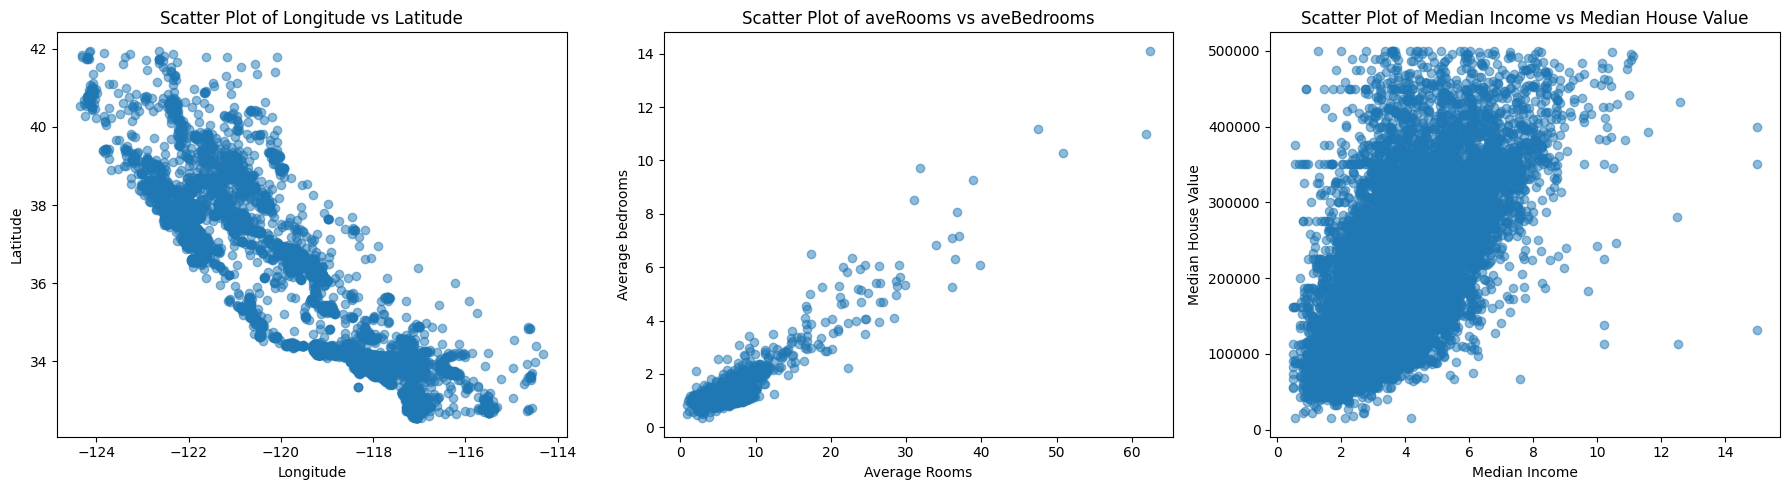

In [8]:
# Scatter plot for the three correlated pairs indentified above)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# First pair: longitude vs latitude
axes[0].scatter(rt_train_data["longitude"], rt_train_data["latitude"], alpha=0.5)
axes[0].set_title("Scatter Plot of Longitude vs Latitude")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Second pair: aveRooms vs aveBedrooms
axes[1].scatter(rt_train_data["aveRooms"], rt_train_data["aveBedrooms"], alpha=0.5)
axes[1].set_title("Scatter Plot of aveRooms vs aveBedrooms")
axes[1].set_xlabel("Average Rooms")
axes[1].set_ylabel("Average bedrooms")

# Third pair: medianIncome vs medianHouseValue
axes[2].scatter(
    rt_train_data["medianIncome"], rt_train_data["medianHouseValue"], alpha=0.5
)
axes[2].set_title("Scatter Plot of Median Income vs Median House Value")
axes[2].set_xlabel("Median Income")
axes[2].set_ylabel("Median House Value")

plt.tight_layout()
plt.show()

### 3. Build and assess multiple linear regression(MLR) model

#### 3.1 Building MLR models

MLR model 1a: using all relevant predictors in the full training dataset

                            OLS Regression Results                            
Dep. Variable:       medianHouseValue   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     2368.
Date:                Fri, 01 Aug 2025   Prob (F-statistic):               0.00
Time:                        16:41:13   Log-Likelihood:            -2.0594e+05
No. Observations:               16346   AIC:                         4.119e+05
Df Residuals:                   16334   BIC:                         4.120e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


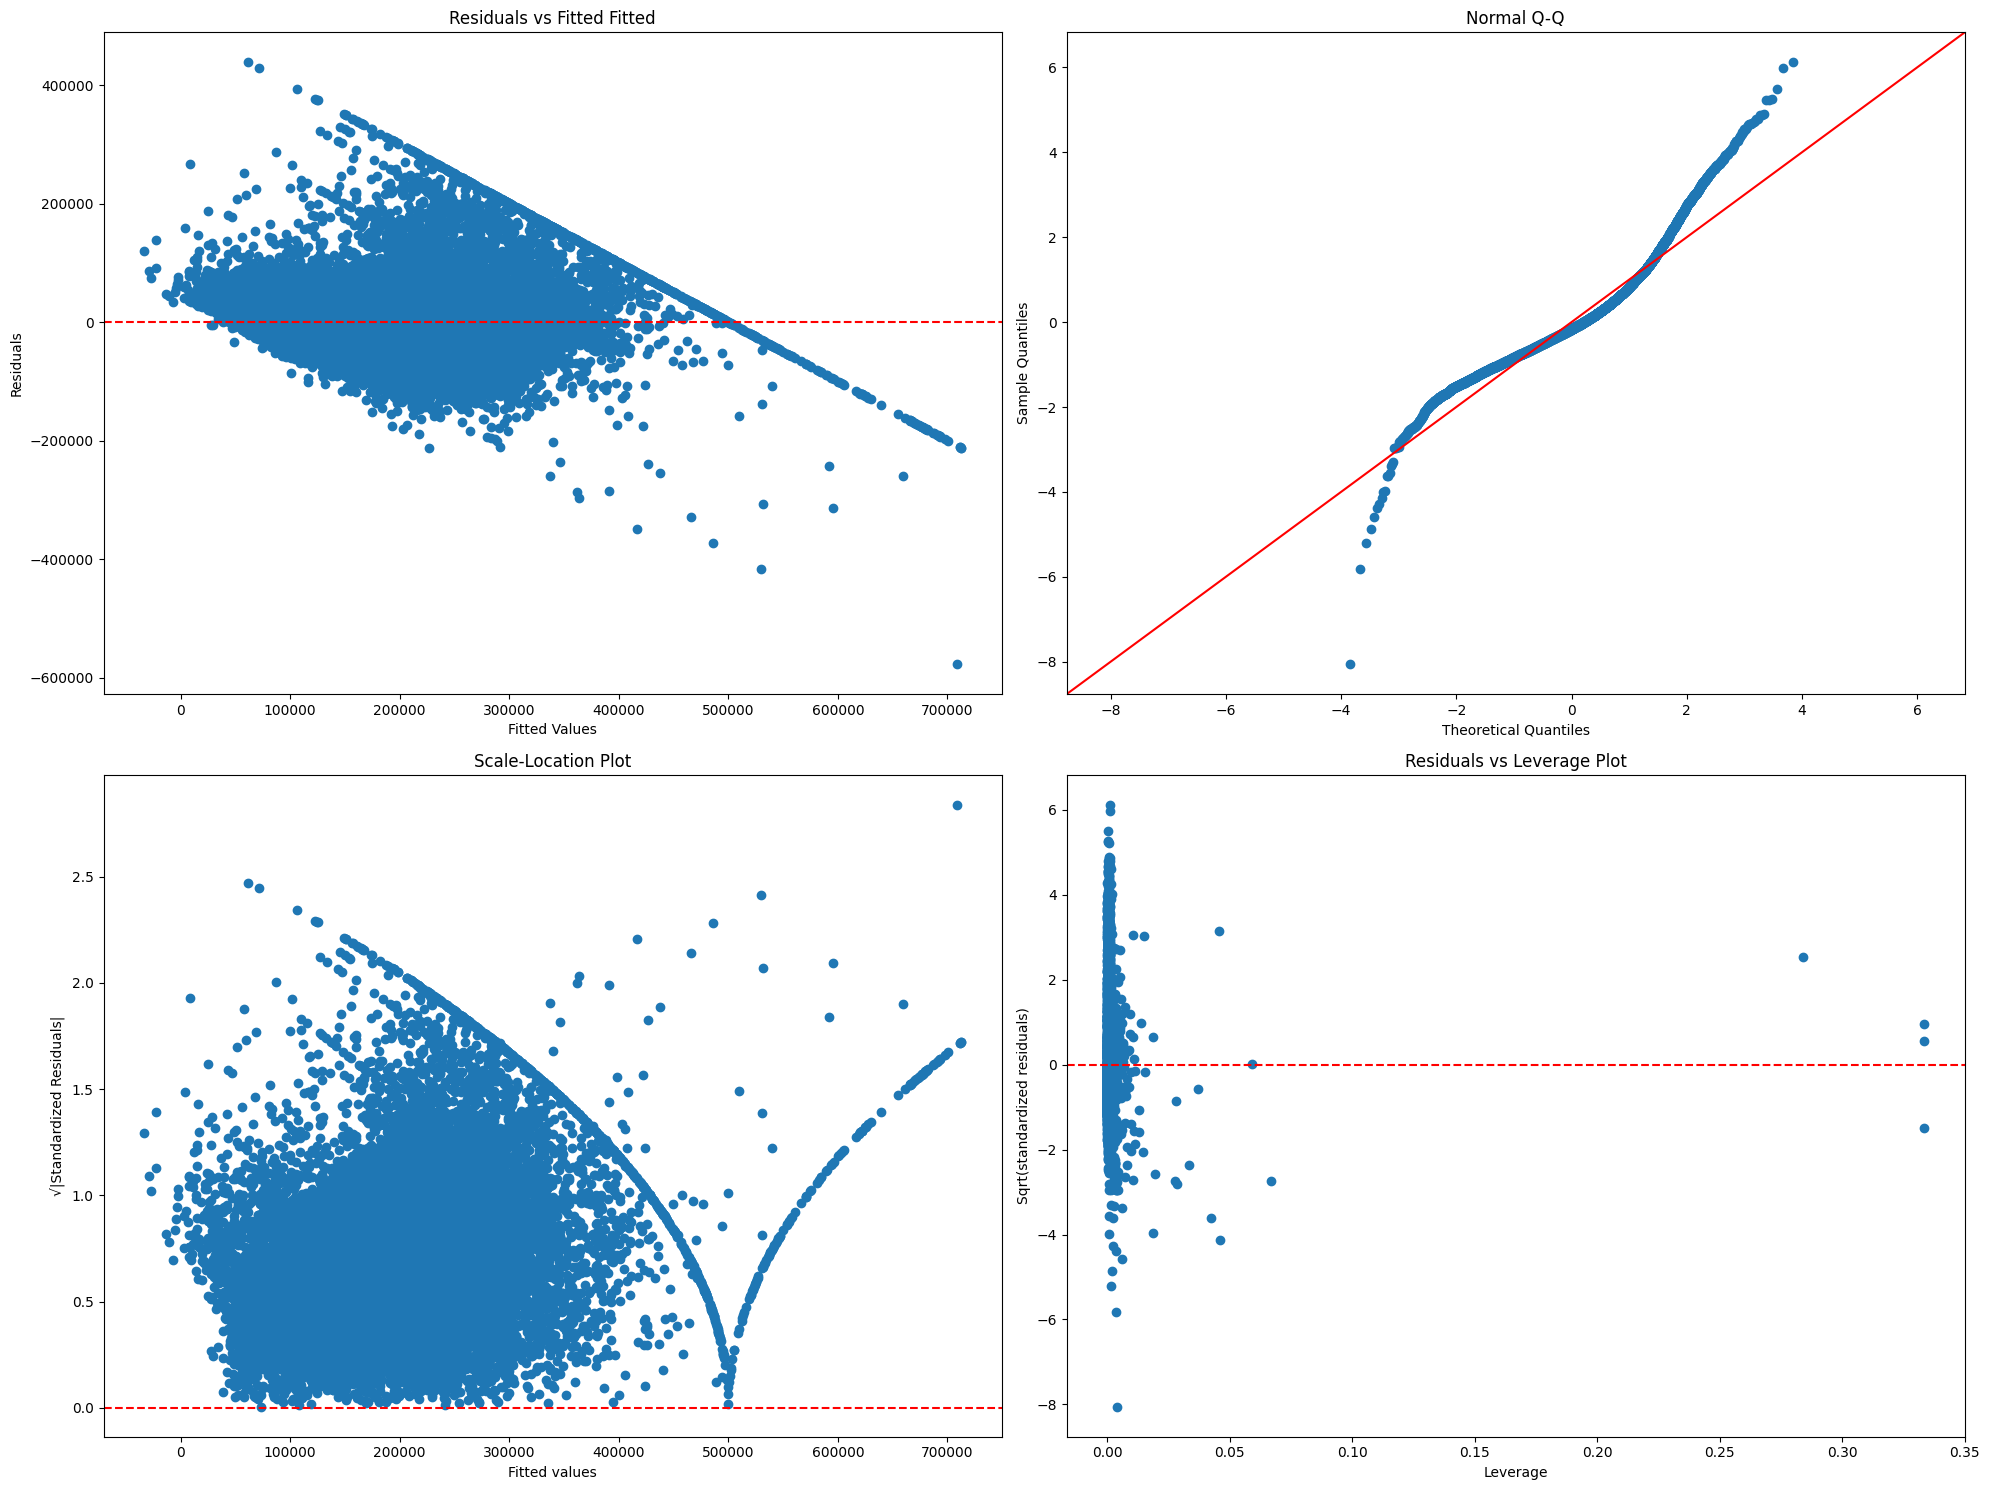

In [9]:
predictor_cols = [col for col in train_data.columns if col != "medianHouseValue"]

# Build MLR model for prediction (latter)
train_X = train_data[predictor_cols]
train_y = train_data["medianHouseValue"]
lm_fit_1a = LinearRegression()
lm_fit_1a.fit(train_X, train_y)

# Build MLR model for inference
predictors = [col for col in train_data.columns if col != "medianHouseValue"]
formula = "medianHouseValue ~ " + " + ".join(predictor_cols)
results = ols(formula, data=train_data).fit()
print(results.summary())

# Reference: Adapted from https://www.geeksforgeeks.org/machine-learning/residual-leverage-plot-regression-diagnostic/
# Get different Variables for diagnostic
residuals = results.resid
fitted_value = results.fittedvalues
stand_resids = results.resid_pearson
influence = results.get_influence()
leverage = influence.hat_matrix_diag

# PLot different diagnostic plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

# Residual vs Fitted Plot
axes[0, 0].scatter(fitted_value, residuals, alpha=1)
axes[0, 0].axhline(y=0, color="red", linestyle="dashed")
axes[0, 0].set_xlabel("Fitted Values")
axes[0, 0].set_ylabel("Residuals")
axes[0, 0].set_title("Residuals vs Fitted Fitted")

# Normal Q-Q plot
sm.qqplot(residuals, fit=True, line="45", ax=axes[0, 1], c="#4C72B0")
axes[0, 1].set_title("Normal Q-Q")

# Scale-Location Plot
axes[1, 0].scatter(fitted_value, np.sqrt(np.abs(stand_resids)), alpha=1)
axes[1, 0].axhline(y=0, color="red", linestyle="dashed")
axes[1, 0].set_xlabel("Fitted values")
axes[1, 0].set_ylabel("√|Standardized Residuals|")
axes[1, 0].set_title("Scale-Location Plot")

# Residual vs Leverage Plot
axes[1, 1].scatter(leverage, stand_resids, alpha=1)
axes[1, 1].axhline(y=0, color="red", linestyle="dashed")
axes[1, 1].set_xlabel("Leverage")
axes[1, 1].set_ylabel("Sqrt(standardized residuals)")
axes[1, 1].set_title("Residuals vs Leverage Plot")

plt.tight_layout()
plt.show()

1. By examnining the F-test p-value, the population variable does not seem to have a significant relationship with the medianHouseValue variable. Other predictors are significant. 
2. The model explains about 61.5% of the variance in the response variable, which indicates a reasonable fit.
3. The residual vs fitted value plot fans out, which suggests heteroscedasticity and a transformation on the response variable may be appropriate.
4. The QQ plot suggests a heavy-tailed distribution compared to the theoretical normal distribution, this will require investigation into outliers and potential transformation of response variable.

In [10]:
# VIF calculation
vif_data = pd.DataFrame()
vif_data["Feature"] = train_X.columns
vif_data["VIF"] = [
    variance_inflation_factor(sm.add_constant(train_X).values, i)
    for i in range(len(train_X.columns))
]
print("\nVariance Inflation Factors:")
print(vif_data)


Variance Inflation Factors:
                      Feature           VIF
0                   longitude  33958.225469
1                    latitude     18.226968
2            housingMedianAge     20.249929
3                    aveRooms      1.297772
4                 aveBedrooms      7.465742
5                  population      6.136063
6                medianIncome      1.134446
7       oceanProximity_INLAND      2.663746
8       oceanProximity_ISLAND      2.909667
9     oceanProximity_NEAR_BAY      1.001924
10  oceanProximity_NEAR_OCEAN      1.554960


1. VIF for longitude is very large which indicates strong multicollinearity. This may be because that variation in longitude can be explained by other spacially-related features such as latitude, medianIncome or oceanProximity.
2. VIF for latitude and hosingMedianAge are high too (above 10), this may due to their correlation with geographical positions.

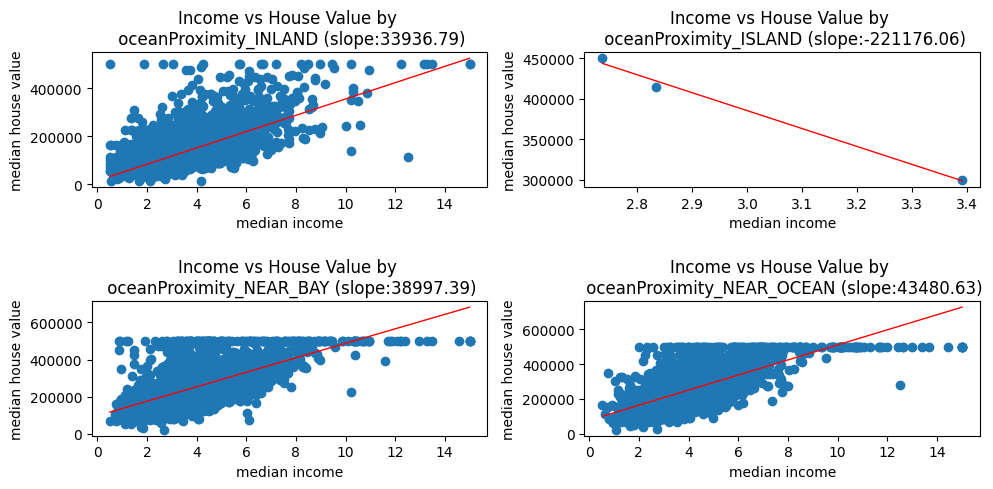

In [106]:
dummy_cols = [col for col in train_data.columns if col.startswith("oceanProximity")]
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
for i, col in enumerate(dummy_cols):
    subset = train_data[train_data[col] == 1]
    x = subset["medianIncome"]
    y = subset["medianHouseValue"]
    slope, intercept = stats.linregress(x, y)[:2]
    line_x = np.linspace(x.min(), x.max(), 100)
    line_y = slope * line_x + intercept
    axes[i // 2, i % 2].scatter(x, y)
    axes[i // 2, i % 2].plot(line_x, line_y, color="red", linewidth=1)
    axes[i // 2, i % 2].set_xlabel("median income")
    axes[i // 2, i % 2].set_ylabel("median house value")
    axes[i // 2, i % 2].set_title(
        f"Income vs House Value by \n {col} (slope:{slope:.2f})"
    )

plt.tight_layout(h_pad=2)
plt.show()

As the fitted linear regression lines show different slopes, this can suggest that the relationship bewteen medianIncome and medianHouseValue changes depending on oceanProximity. Therefore, an interaction term between oceanProximity and medianIncome could be added to the initial model.

MLR model 1b: initial MLR trained using truncated training data

In [12]:
rt_train_X = rt_train_data[predictor_cols]
rt_train_y = rt_train_data["medianHouseValue"]
lm_fit_1b = LinearRegression()
lm_fit_1b.fit(rt_train_X, rt_train_y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


MLR model 2a: select a subset of predictors that are significant and aiming to remove multicollinearity issue. Fitted using the original data.

In [13]:
# Population is statistically insignificant
# Longitude is removed to address the multicollinearity due geographical features
# AveBedrooms is also removed to address multicollinearity issue
short_predictor_cols = [
    col
    for col in rt_train_data.columns
    if col not in ["medianHouseValue", "population", "longitude", "aveBedrooms"]
]
lm_fit_2a = LinearRegression()
lm_fit_2a.fit(train_data[short_predictor_cols], train_data["medianHouseValue"])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


MLR model 2b: select a subset of predictors that are significant and aiming to remove multicollinearity issue. Fitted using the truncated data.

In [14]:
lm_fit_2b = LinearRegression()
lm_fit_2b.fit(rt_train_data[short_predictor_cols], rt_train_data["medianHouseValue"])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


MLR model 3a: Add an interaction term between medianIncome and oceanProximity. Fitted using the original data

In [ ]:
# Create interaction term
train_data_interaction = train_data.copy()
for col in dummy_cols:
    train_data_interaction[f"{col}_x_medianIncome"] = (
        train_data[col] * train_data["medianIncome"]
    )

long_predictor_cols = [
    col for col in train_data_interaction.columns if col != "medianHouseValue"
]
lm_fit_3a = LinearRegression()
lm_fit_3a.fit(
    train_data_interaction[long_predictor_cols],
    train_data_interaction["medianHouseValue"],
)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


MLR model 3b: Add an interaction term between medianIncome and oceanProximity. Fitted using the truncated data

In [16]:
# Create interaction term for truncated data
dummy_cols = [col for col in train_data.columns if col.startswith("oceanProximity")]
rt_train_data_interaction = rt_train_data.copy()
for col in dummy_cols:
    rt_train_data_interaction[f"{col}_x_medianIncome"] = (
        rt_train_data[col] * rt_train_data["medianIncome"]
    )

lm_fit_3b = LinearRegression()
lm_fit_3b.fit(
    rt_train_data_interaction[long_predictor_cols],
    rt_train_data_interaction["medianHouseValue"],
)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


MLR model 4a: address multicollinearity issue using ridge regression. Fitted using the original data.

In [17]:
test_X = test_data[predictor_cols]
test_y = test_data["medianHouseValue"]

# Standardize the predictors
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

# Find the best alpha using cross-validation
ridge_cv = RidgeCV(alphas=np.logspace(10, -2, num=100, base=10), cv=5)
ridge_cv.fit(train_X_scaled, train_y)
best_alpha1 = ridge_cv.alpha_
print("Best alpha:", best_alpha1)

# Fit redge regression model
ridge = Ridge(alpha=best_alpha1)
lm_fit_4a = ridge.fit(train_X_scaled, train_y)

Best alpha: 4.641588833612772


MLR model 4b: address multicollinearity issue using ridge regression. Fitted using the truncated data.

In [18]:
rt_test_X = rt_test_data[predictor_cols]
rt_test_y = rt_test_data["medianHouseValue"]

# Standardize the predictors
scaler = StandardScaler()
rt_train_X_scaled = scaler.fit_transform(rt_train_X)
rt_test_X_scaled = scaler.transform(rt_test_X)

# Find the best alpha using cross-validation
ridge_cv = RidgeCV(alphas=np.logspace(10, -2, num=100, base=10), cv=5)
ridge_cv.fit(rt_train_X_scaled, rt_train_y)
best_alpha2 = ridge_cv.alpha_
print("Best alpha:", best_alpha2)

# Fit redge regression model
ridge = Ridge(alpha=best_alpha2)
lm_fit_4b = ridge.fit(rt_train_X_scaled, rt_train_y)

Best alpha: 8.111308307896856


MLR model 5a: Build a PCR model using all predictors and the original data

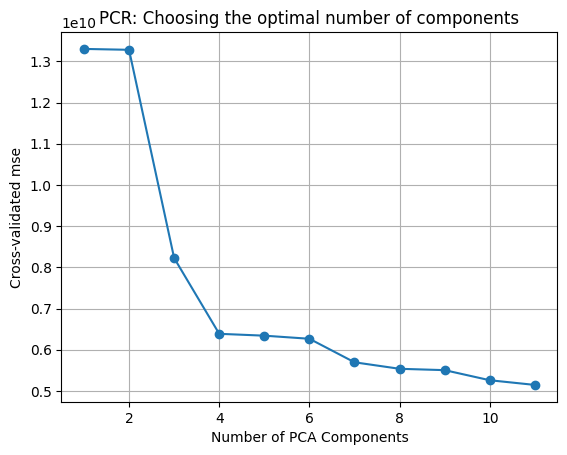

Optimal number of components: 4


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [19]:
# Apply PCA
pca = PCA()
train_X_pca = pca.fit_transform(train_X_scaled)

# Determine optimal number of components via cross-validation
pca_mse = []
n_components = train_X_scaled.shape[1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

for i in range(1, n_components + 1):
    train_X_reduced = train_X_pca[:, :i]
    scores = -1 * cross_val_score(
        LinearRegression(),
        train_X_reduced,
        train_y,
        scoring="neg_mean_squared_error",
        cv=kf,
    )
    pca_mse.append(scores.mean())

plt.plot(range(1, n_components + 1), pca_mse, marker="o")
plt.xlabel("Number of PCA Components")
plt.ylabel("Cross-validated mse")
plt.title("PCR: Choosing the optimal number of components")
plt.grid(True)
plt.show()

optimal_components = 4  # Based on the plot
print(f"Optimal number of components: {optimal_components}")

train_X_reduced_final = train_X_pca[:, :optimal_components]
lm_fit_5a = LinearRegression()
lm_fit_5a.fit(train_X_reduced_final, train_y)

MLR model 5b: Build a PCR model using all predictors and the truncated data

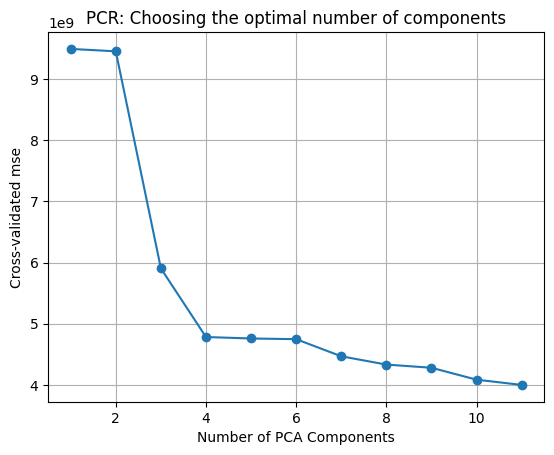

Optimal number of components: 4


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [20]:
# Apply PCA
pca = PCA()
rt_train_X_pca = pca.fit_transform(rt_train_X_scaled)

# Determine optimal number of components via cross-validation
pca_mse = []
n_components = rt_train_X_scaled.shape[1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

for i in range(1, n_components + 1):
    rt_train_X_reduced = rt_train_X_pca[:, :i]
    scores = -1 * cross_val_score(
        LinearRegression(),
        rt_train_X_reduced,
        rt_train_y,
        scoring="neg_mean_squared_error",
        cv=kf,
    )
    pca_mse.append(scores.mean())

plt.plot(range(1, n_components + 1), pca_mse, marker="o")
plt.xlabel("Number of PCA Components")
plt.ylabel("Cross-validated mse")
plt.title("PCR: Choosing the optimal number of components")
plt.grid(True)
plt.show()

optimal_components = 4  # Based on the plot
print(f"Optimal number of components: {optimal_components}")

rt_train_X_reduced_final = rt_train_X_pca[:, :optimal_components]
lm_fit_5b = LinearRegression()
lm_fit_5b.fit(rt_train_X_reduced_final, rt_train_y)

#### 3.2 Compare best two models using training and estimated test MSE

In [21]:
training_mse_a = list()
training_mse_b = list()

training_mse_a.append(mean_squared_error(train_y, lm_fit_1a.predict(train_X)))
training_mse_b.append(mean_squared_error(rt_train_y, lm_fit_1b.predict(rt_train_X)))

training_mse_a.append(
    mean_squared_error(train_y, lm_fit_2a.predict(train_X[short_predictor_cols]))
)
training_mse_b.append(
    mean_squared_error(rt_train_y, lm_fit_2b.predict(rt_train_X[short_predictor_cols]))
)

training_mse_a.append(
    mean_squared_error(
        train_y, lm_fit_3a.predict(train_data_interaction[long_predictor_cols])
    )
)
training_mse_b.append(
    mean_squared_error(
        rt_train_y, lm_fit_3b.predict(rt_train_data_interaction[long_predictor_cols])
    )
)

training_mse_a.append(mean_squared_error(train_y, lm_fit_4a.predict(train_X_scaled)))
training_mse_b.append(
    mean_squared_error(rt_train_y, lm_fit_4b.predict(rt_train_X_scaled))
)

training_mse_a.append(
    mean_squared_error(train_y, lm_fit_5a.predict(train_X_reduced_final))
)
training_mse_b.append(
    mean_squared_error(rt_train_y, lm_fit_5b.predict(rt_train_X_reduced_final))
)

print("\nTraining MSE for each model using original data:", training_mse_a)
print("\nThe model with the lowest training MSE is:", np.argmin(training_mse_a) + 1)
print(
    "\nThe model with the second lowest training MSE is:",
    np.argsort(training_mse_a)[1] + 1,
)

print("\nTraining MSE for each model using truncated data:", training_mse_b)
print("\nThe model with the lowest training MSE is:", np.argmin(training_mse_b) + 1)
print(
    "\nThe model with the second lowest training MSE is:",
    np.argsort(training_mse_b)[1] + 1,
)


Training MSE for each model using original data: [5137569378.412887, 5411937934.601615, 5113160576.012728, 5137587749.083364, 6362308076.30935]

The model with the lowest training MSE is: 3

The model with the second lowest training MSE is: 1

Training MSE for each model using truncated data: [3987406663.3747854, 4210723440.284385, 3955915421.4583983, 3987450818.3432474, 4777882875.340608]

The model with the lowest training MSE is: 3

The model with the second lowest training MSE is: 1


Model 1 and 3 apppear to be have better performances when using the full and truncated training dataset. This suggests that the two models are not underfitting the tails (censoring threshold) or not overfitting to values below the censoring threshold. In the following section, the performance of these two models will be further assessed.

1. Training MSE of the two models (as calculated above)

In [22]:
# Without censoring the predicted values
print("\nTraining MSE for model 1 using original data:", training_mse_a[0])
print("\nTraining MSE for model 1 using truncated data:", training_mse_b[0])
print("\nTraining MSE for model 3 using original data:", training_mse_a[2])
print("\nTraining MSE for model 3 using truncated data:", training_mse_b[2])


# Censoring the predicted values
def censored_mse(*args, censor_value=censor_houseValue):
    """
    Calculate the mean squared error with censored predictions.
    """
    y_true = args[0]
    y_pred = args[1]

    # Censor the predictions
    y_pred_censored = np.minimum(y_pred, censor_value)

    return mean_squared_error(y_true, y_pred_censored)


print(
    "\nCensored Training MSE for model 1 using original data:",
    censored_mse(train_y, lm_fit_1a.predict(train_X)),
)
print(
    "\nCensored Training MSE for model 1 using truncated data:",
    censored_mse(rt_train_y, lm_fit_1b.predict(rt_train_X)),
)
print(
    "\nCensored Training MSE for model 3 using original data:",
    censored_mse(
        train_y, lm_fit_3a.predict(train_data_interaction[long_predictor_cols])
    ),
)
print(
    "\nCensored Training MSE for model 3 using truncated data:",
    censored_mse(
        rt_train_y, lm_fit_3b.predict(rt_train_data_interaction[long_predictor_cols])
    ),
)


Training MSE for model 1 using original data: 5137569378.412887

Training MSE for model 1 using truncated data: 3987406663.3747854

Training MSE for model 3 using original data: 5113160576.012728

Training MSE for model 3 using truncated data: 3955915421.4583983

Censored Training MSE for model 1 using original data: 5011603186.1400585

Censored Training MSE for model 1 using truncated data: 3966930743.4543567

Censored Training MSE for model 3 using original data: 4973807682.10711

Censored Training MSE for model 3 using truncated data: 3933356317.0935154


Model 3 has better performance using both original and truncated training data. In addition, censoring the predicted values reduces the training MSE for all cases. 

2. A 80-20 split and the validation set approach to estimate test MSE

In [23]:
train_data_80, train_data_20 = train_test_split(
    train_data, test_size=0.2, random_state=1
)
train_X_80 = train_data_80[predictor_cols]
train_y_80 = train_data_80["medianHouseValue"]
train_X_20 = train_data_20[predictor_cols]
train_y_20 = train_data_20["medianHouseValue"]

train_data_80_interaction = train_data_80.copy()
for col in dummy_cols:
    train_data_80_interaction[f"{col}_x_medianIncome"] = (
        train_data_80[col] * train_data_80["medianIncome"]
    )

train_data_20_interaction = train_data_20.copy()
for col in dummy_cols:
    train_data_20_interaction[f"{col}_x_medianIncome"] = (
        train_data_20[col] * train_data_20["medianIncome"]
    )

# Fit the model on the 80% training set
lm_fit_1a_80 = LinearRegression()
lm_fit_1a_80.fit(train_X_80, train_y_80)

lm_fit_3a_80 = LinearRegression()
lm_fit_3a_80.fit(
    train_data_80_interaction[long_predictor_cols],
    train_data_80_interaction["medianHouseValue"],
)

print(
    "\nEstimated test MSE for model 1:",
    mean_squared_error(train_y_20, lm_fit_1a_80.predict(train_X_20)),
)
print(
    "\nEstimated test MSE for model 3:",
    mean_squared_error(
        train_y_20, lm_fit_3a_80.predict(train_data_20_interaction[long_predictor_cols])
    ),
)

print(
    "\nCensored Estimated test MSE for model 1:",
    censored_mse(train_y_20, lm_fit_1a_80.predict(train_X_20)),
)
print(
    "\nCensored Estimated test MSE for model 3:",
    censored_mse(
        train_y_20, lm_fit_3a_80.predict(train_data_20_interaction[long_predictor_cols])
    ),
)


Estimated test MSE for model 1: 5367206025.053352

Estimated test MSE for model 3: 5365270471.895398

Censored Estimated test MSE for model 1: 5213283910.584253

Censored Estimated test MSE for model 3: 5181685970.631287


Model 3 has better performance in this case and censoring the predicted values helps in reducing the estimated test MSE.

3. 5-fold cross-validation to estimate test MSE

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
neg_mse_1 = cross_val_score(
    lm_fit_1a, train_X, train_y, scoring="neg_mean_squared_error", cv=kf
)
print("\nEstimated test MSE for model 1: ", -neg_mse_1.mean())

neg_mse_3 = cross_val_score(
    lm_fit_3a,
    train_data_interaction[long_predictor_cols],
    train_data_interaction["medianHouseValue"],
    scoring="neg_mean_squared_error",
    cv=kf,
)
print("\nEstimated test MSE for model 3: ", -neg_mse_3.mean())

censored_mse_scorer = make_scorer(censored_mse, greater_is_better=False)
censored_neg_mse_1 = cross_val_score(
    lm_fit_1a, train_X, train_y, scoring=censored_mse_scorer, cv=kf
)
print("\nCensored Estimated test MSE for model 1: ", -censored_neg_mse_1.mean())
censored_neg_mse_3 = cross_val_score(
    lm_fit_3a,
    train_data_interaction[long_predictor_cols],
    train_data_interaction["medianHouseValue"],
    scoring=censored_mse_scorer,
    cv=kf,
)
print("\nCensored Estimated test MSE for model 3: ", -censored_neg_mse_3.mean())


Estimated test MSE for model 1:  5146900144.004133

Estimated test MSE for model 3:  5127717633.746809

Censored Estimated test MSE for model 1:  5019424541.123624

Censored Estimated test MSE for model 3:  4984454095.971665


Model 3 has better performance in this case and censoring the predicted values helps in reducing the estimated test MSE.

4. LOOCV approach to estimate test MSE

In [25]:
loo = LeaveOneOut()
neg_mse_1 = cross_val_score(
    lm_fit_1a, train_X, train_y, scoring="neg_mean_squared_error", cv=loo
)
print("\nEstimated test MSE for model 1: ", -neg_mse_1.mean())

neg_mse_3 = cross_val_score(
    lm_fit_3a,
    train_data_interaction[long_predictor_cols],
    train_data_interaction["medianHouseValue"],
    scoring="neg_mean_squared_error",
    cv=loo,
)
print("\nEstimated test MSE for model 3: ", -neg_mse_3.mean())

censored_neg_mse_1 = cross_val_score(
    lm_fit_1a, train_X, train_y, scoring=censored_mse_scorer, cv=loo
)
print("\nCensored Estimated test MSE for model 1: ", -censored_neg_mse_1.mean())
censored_neg_mse_3 = cross_val_score(
    lm_fit_3a,
    train_data_interaction[long_predictor_cols],
    train_data_interaction["medianHouseValue"],
    scoring=censored_mse_scorer,
    cv=loo,
)
print("\nCensored Estimated test MSE for model 3: ", -censored_neg_mse_3.mean())


Estimated test MSE for model 1:  5150941941.375576

Estimated test MSE for model 3:  5128477494.598352

Censored Estimated test MSE for model 1:  5023938852.29528

Censored Estimated test MSE for model 3:  4986261857.217244


Model 3 has better performance in this case and censoring the predicted values helps in reducing the estimated test MSE.

5. Conclusion

Overall, model 3, which has an additional interaction term, appears to perform better than the initial MLR. It appears that, compared to the more restrictive improvements (such as reducing predictors, applying ridge regression, or using PCR), increasing the flexibility of the initial MLR model yields more substantial performance gains. This can be justified as the flexibility of the initial linear model is quite limited, the reduction in model bias outweighs the corresponding increase in variance. Further improvements could involve adopting non-linear or non-parametric models, which will be discussed in Section 4.

#### 3.3 Compute test MSE using the selected best MLR model

In [26]:
test_data_interaction = test_data.copy()
for col in dummy_cols:
    test_data_interaction[f"{col}_x_medianIncome"] = (
        test_data[col] * test_data["medianIncome"]
    )

print(
    "\nTest MSE of model 3:",
    censored_mse(test_y, lm_fit_3a.predict(test_data_interaction[long_predictor_cols])),
)


Test MSE of model 3: 4807286700.671376


### 4. Compare Generalized Additive (GAM) Model with K-Nearest Neighbors (KNN) regression model

Following the proposed improvement above, GAM model is selected for non-linear models and KNN regression model is selected for non-parametric models.

1. GAM model

For GAM regression model, the categorical variables (oceanProximity) would not be used. Although it can be converted into dummy variables, there is limited benefit in using GAM's flexibliity for variables taking 0/1.    

In [27]:
# Remove dummy variables for GAM
train_data_gam = train_data.drop(dummy_cols, axis=1)
test_data_gam = test_data.drop(dummy_cols, axis=1)
predictor_cols_gam = [
    col for col in train_data_gam.columns if col != "medianHouseValue"
]
train_X_gam = train_data_gam[predictor_cols_gam]
train_y_gam = train_data_gam["medianHouseValue"]
test_X_gam = test_data_gam[predictor_cols_gam]
test_y_gam = test_data_gam["medianHouseValue"]

gam_fit = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6)).fit(
    train_X_gam, train_y_gam
)
gam_fit.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     83.0697
Link Function:                     IdentityLink Log Likelihood:                               -377481.4118
Number of Samples:                        16346 AIC:                                            755130.963
                                                AICc:                                          755131.8426
                                                GCV:                                       4306729904.7482
                                                Scale:                                     4267351877.3733
                                                Pseudo R-Squared:                                   0.6815
Feature Function                  Lam

C:\Users\haili\AppData\Local\Temp\ipykernel_82364\1697259199.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_fit.summary()


In [28]:
print(
    "\nCensored test MSE of GAM model :",
    censored_mse(test_y_gam, gam_fit.predict(test_X_gam)),
)


Censored test MSE of GAM model : 4052103462.997527


2. KNN regression model

For KNN regression model, the categorical variables (oceanProximity) would not be used as it could distort distance calculations and results in rigid boundaries. Furthermore, spacial-related predictors including longitude, latitude and medianIncome are selected to reduce the negative effect of high dimensionality on the accuracy of KNN models. 

In [29]:
knn_cols = ["longitude", "latitude", "medianIncome"]
train_X_knn = train_data[knn_cols]
train_y_knn = train_data["medianHouseValue"]
test_X_knn = test_data[knn_cols]
test_y_knn = test_data["medianHouseValue"]

k_mse = list()
for k in range(1, 100):
    scores = -1 * cross_val_score(
        KNeighborsRegressor(n_neighbors=k),
        train_X_knn,
        train_y_knn,
        scoring="neg_mean_squared_error",
        cv=kf,
    )
    k_mse.append(scores.mean())

print("\nBest K:", np.argmin(k_mse) + 1)


Best K: 6


In [30]:
knn_fit_reg = KNeighborsRegressor(n_neighbors=np.argmin(k_mse) + 1).fit(
    train_X_knn, train_y_knn
)
print(
    "\nCensored test MSE of KNN model:",
    censored_mse(test_y_knn, knn_fit_reg.predict(test_X_knn)),
)


Censored test MSE of KNN model: 2950084198.5891175


Comparing the test MSE, the KNN regression model appears to have better performance. Both models are advantageous in their flexiblity. While the GAM model could be further improved by adjusting for correlation among the predictors (to meet model assumptions) and performing variable selection (to reduce flexibility), the KNN model with only three predictors uses a non-parametric approach and has a more suitable level of flexibility compared to the GAM model. In this case, we will consider KNN regression model for the rest of the analysis. 

### 5. Build and assess classification models

In this section, we will try building two classification models to predict the censoring of the response variable (medianHouseValue) given corresponding observations from predictor variables. 

Candiate classification models are logistic regression, linear discriminant analysis (LDA), quadratic discriminant alaysis (QDA) and KNN classification model.

The MLR model built in section 3 suggests that there exists significant linear relationships between medianHouseValue and most predictors. In addition, the histograms of the truncated data set plotted in Section 2 suggest that the preditors are unlikely normally distributed, which does not meet the assumptions required by LDA and QDA. In conclusion, logistic regression and KNN classification model will be built and assessed in this section.

1. Logistic regression model

In [31]:
# Create a binary response variable for classification
censor = list()
for value in full_data["medianHouseValue"]:
    if value < censor_houseValue:
        censor.append(0)
    else:
        censor.append(1)

full_data_class = full_data.drop(columns=["medianHouseValue"])
full_data_class["censor"] = censor
train_data_class, test_data_class = train_test_split(
    full_data_class, test_size=0.2, random_state=1
)

In [32]:
# model 1: using all predictors

# Extract and scale predictors
train_X_class = train_data_class.drop(columns=["censor"])
train_y_class = train_data_class["censor"]
test_X_class = test_data_class.drop(columns=["censor"])
test_y_class = test_data_class["censor"]

scaler2 = StandardScaler()
train_X_class = scaler2.fit_transform(train_X_class)
test_X_class = scaler2.transform(test_X_class)

# For inference
X_wconstant = sm.add_constant(train_X_class)
logit_model = sm.Logit(train_y_class, X_wconstant)
results_logit = logit_model.fit()
print(results_logit.summary())
pvalues = results_logit.pvalues[1:]
indexes = np.where(pvalues > 0.05)[0]
insig_predictors = []
for i in indexes:
    insig_predictors.append(predictor_cols[i])
print("\nPredictors that are statistically insignifcant:", insig_predictors)

# For prediction (test error rate)
logit_fit1 = LogisticRegression(max_iter=100)
logit_fit1.fit(train_X_class, train_y_class)
y_pred_class = logit_fit1.predict(test_X_class)
print(
    f"\nTest error rate of logistic regression model 1: {(1 - accuracy_score(test_y_class, y_pred_class)):.5f}"
)
print("\nConfusion matrix:\n", confusion_matrix(test_y_class, y_pred_class))
print("\nClassification report:\n", classification_report(test_y_class, y_pred_class))

         Current function value: 0.099041
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 censor   No. Observations:                16346
Model:                          Logit   Df Residuals:                    16334
Method:                           MLE   Df Model:                           11
Date:                Fri, 01 Aug 2025   Pseudo R-squ.:                  0.4769
Time:                        16:50:01   Log-Likelihood:                -1618.9
converged:                      False   LL-Null:                       -3095.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6669    117.006     -0.048      0.961    -234.995     223.661
x1            -4.1480      0.337    -12.308      0.000      -4.80

C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
# model 2: using selected predictors
# population removed as it is statistically insignificant
# longitude and aveBedrooms removed to address multicollinearity issue

# Extract and scale predictors
train_X_class2 = train_data_class.drop(
    columns=["censor", "population", "longitude", "aveRooms"]
)
test_X_class2 = test_data_class.drop(
    columns=["censor", "population", "longitude", "aveRooms"]
)

scaler2 = StandardScaler()
train_X_class2 = scaler2.fit_transform(train_X_class2)
test_X_class2 = scaler2.transform(test_X_class2)

# For inference
X2_wconstant = sm.add_constant(train_X_class2)
results_logit2 = sm.Logit(train_y_class, X2_wconstant).fit()
print(results_logit2.summary())
pvalues2 = results_logit2.pvalues[1:]
indexes2 = np.where(pvalues2 > 0.05)[0]
insig_predictors2 = []
for i in indexes2:
    insig_predictors2.append(short_predictor_cols[i])
print("\nPredictors that are statistically insignifcant:", insig_predictors2)

# For prediction (test error rate)
logit_fit2 = LogisticRegression(max_iter=100)
logit_fit2.fit(train_X_class2, train_y_class)
y_pred_class2 = logit_fit2.predict(test_X_class2)
print(
    f"\nTest error rate of logistic regression model 2: {(1 - accuracy_score(test_y_class, y_pred_class2)):.5f}"
)
print("\nConfusion matrix:\n", confusion_matrix(test_y_class, y_pred_class2))
print("\nClassification report:\n", classification_report(test_y_class, y_pred_class2))

         Current function value: 0.106331
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 censor   No. Observations:                16346
Model:                          Logit   Df Residuals:                    16337
Method:                           MLE   Df Model:                            8
Date:                Fri, 01 Aug 2025   Pseudo R-squ.:                  0.4385
Time:                        16:50:01   Log-Likelihood:                -1738.1
converged:                      False   LL-Null:                       -3095.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8939    280.116     -0.017      0.986    -553.911     544.123
x1            -0.3935      0.076     -5.157      0.000      -0.54

C:\Users\haili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


It appears that the first logistic regression model performs better.

2. KNN model

In [34]:
# model 1: use all predictors
k_error_rate = list()
for k in range(1, 50):
    scores = cross_val_score(
        KNeighborsClassifier(n_neighbors=k), train_X_class, train_y_class, cv=kf
    )
    k_error_rate.append(1 - scores.mean())

print("\nBest K:", np.argmin(k_error_rate) + 1)

knn_fit_class1 = KNeighborsClassifier(n_neighbors=np.argmin(k_error_rate) + 1).fit(
    train_X_class, train_y_class
)
y_pred_knn = knn_fit_class1.predict(test_X_class)
print(
    f"\nTest error rate of KNN model: {(1 - accuracy_score(test_y_class, y_pred_knn)):.5f}"
)
print("\nConfusion matrix:\n", confusion_matrix(test_y_class, y_pred_knn))
print("\nClassification report:\n", classification_report(test_y_class, y_pred_knn))


Best K: 23

Test error rate of KNN model: 0.03132

Confusion matrix:
 [[3881   15]
 [ 113   78]]

Classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      3896
           1       0.84      0.41      0.55       191

    accuracy                           0.97      4087
   macro avg       0.91      0.70      0.77      4087
weighted avg       0.97      0.97      0.96      4087



In [35]:
# model 2: use selected predictors
train_X_knn2 = train_data_class[knn_cols]
scaler3 = StandardScaler()
train_X_knn2 = scaler3.fit_transform(train_X_knn2)
test_X_knn2 = test_data_class[knn_cols]
test_X_knn2 = scaler3.transform(test_X_knn2)

k_error_rate2 = list()
for k in range(1, 50):
    scores = cross_val_score(
        KNeighborsClassifier(n_neighbors=k), train_X_knn2, train_y_class, cv=kf
    )
    k_error_rate2.append(1 - scores.mean())

print("\nBest K:", np.argmin(k_error_rate2) + 1)

knn_fit_class2 = KNeighborsClassifier(n_neighbors=np.argmin(k_error_rate2) + 1).fit(
    train_X_knn2, train_y_class
)
y_pred_knn = knn_fit_class2.predict(test_X_knn2)
print(
    f"\nTest error rate of KNN model: {(1 - accuracy_score(test_y_class, y_pred_knn)):.5f}"
)
print("\nConfusion matrix:\n", confusion_matrix(test_y_class, y_pred_knn))
print("\nClassification report:\n", classification_report(test_y_class, y_pred_knn))


Best K: 25

Test error rate of KNN model: 0.03083

Confusion matrix:
 [[3873   23]
 [ 103   88]]

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      3896
           1       0.79      0.46      0.58       191

    accuracy                           0.97      4087
   macro avg       0.88      0.73      0.78      4087
weighted avg       0.97      0.97      0.97      4087



3. Compare logistic regression model with KNN model using ROC curve

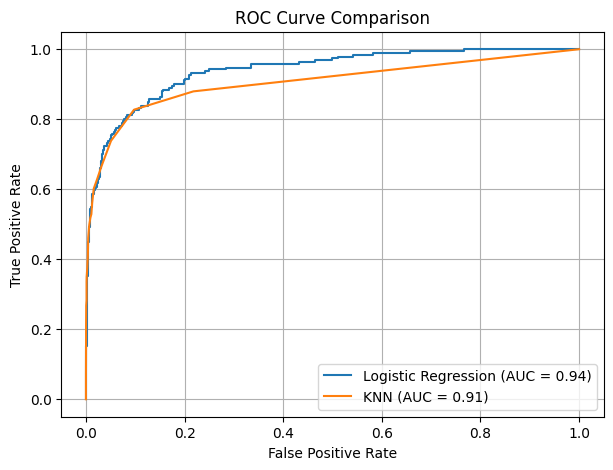

In [36]:
logit_probs = logit_fit1.predict_proba(test_X_class)[:, 1]
knn_probs = knn_fit_class1.predict_proba(test_X_class)[:, 1]

fpr_logit, tpr_logit, _ = roc_curve(test_y_class, logit_probs)
auc_logit = auc(fpr_logit, tpr_logit)
fpr_knn, tpr_knn, _ = roc_curve(test_y_class, knn_probs)
auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(7, 5))
plt.plot(fpr_logit, tpr_logit, label=f"Logistic Regression (AUC = {auc_logit:.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {auc_knn:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

Overall, it appears that the logistic regression model outperforms the KNN classifcation model. Although the KNN classification model is more flexible, its performance is adversely affected by the high dimensionality of the predictors. In addition, it appears that the linear decision boundary fiited using logistic regression works well with the standardised data set.

### 6. Combination of regression model and classifier

In [37]:
# KNN regression model fitted to truncated data
knn_cols = ["longitude", "latitude", "medianIncome"]
rt_train_X_knn = rt_train_X[knn_cols]
rt_train_y_knn = train_y[train_y < censor_houseValue]

k_mse = list()
for k in range(1, 100):
    scores = -1 * cross_val_score(
        KNeighborsRegressor(n_neighbors=k),
        rt_train_X_knn,
        rt_train_y_knn,
        scoring="neg_mean_squared_error",
        cv=kf,
    )
    k_mse.append(scores.mean())

print("\nBest K:", np.argmin(k_mse) + 1)

knn_fit_reg2 = KNeighborsRegressor(n_neighbors=np.argmin(k_mse) + 1).fit(
    rt_train_X_knn, rt_train_y_knn
)


Best K: 7


In [38]:
# prediction using logistic regression model
pred_class = logit_fit1.predict(test_X_class)

# prediction using KNN regression model on class 0
pred_values = knn_fit_reg2.predict(test_X[pred_class == 0][knn_cols])
pred_values[pred_values > censor_houseValue - 1] = censor_houseValue

# Combined results
iter_values = iter(pred_values)
pred_y_combined = [
    censor_houseValue if x == 1 else next(iter_values) for x in pred_class
]

print(
    f"\nTest MSE of the hybrid approach: {mean_squared_error(test_y, pred_y_combined):.5f}"
)


Test MSE of the hybrid approach: 3239093254.55889


Overall, the hybrid approach has lower test MSE compared to the MLR and GAM model yet it underperforms the pure KNN regression model. This could be due to that the KNN regression model in the hybrid approach is fitted to a truncated dataset, which is less generalised for a non-parametric method. In addition, misclassifications from the logistic regression model can results in a biased test data set that is less representitive of the true uncensored data set, thus higher error in the predicted results.